In [88]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import omniglue
from omniglue import utils
from PIL import Image
import cv2
import math
from IPython.display import display



# 合成目录中的图片
def create_image_grid(directory):
    # 获取目录下的所有图片文件
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    # 如果没有图片文件，则退出
    if not image_files:
        print("目录中没有找到图片文件")
        return

    # 打开所有图片并确定它们的大小
    images = [Image.open(os.path.join(directory, img_file)) for img_file in image_files]
    img_width, img_height = images[0].size

    # 计算网格的大小
    grid_size = math.ceil(math.sqrt(len(images)))
    grid_width = img_width * grid_size
    grid_height = img_height * grid_size

    # 创建一个空白图像以容纳所有图片
    grid_image = Image.new('RGB', (grid_width, grid_height),'white')

    # 将每张图片粘贴到网格图像中
    for idx, image in enumerate(images):
        x = (idx % grid_size) * img_width
        y = (idx // grid_size) * img_height
        grid_image.paste(image, (x, y))

    # 保存最终的网格图像
    # output_path = os.path.join(directory, 'merge.png')
    # grid_image.save(output_path)
    display(grid_image)

In [2]:
# Load models.
print("> Loading OmniGlue (and its submodules: SuperPoint & DINOv2)...")
start = time.time()
og = omniglue.OmniGlue(
    og_export="./models/og_export",
    sp_export="./models/sp_v6",
    dino_export="./models/dinov2_vitb14_pretrain.pth",
)
print(f"> \tTook {time.time() - start} seconds.")

> Loading OmniGlue (and its submodules: SuperPoint & DINOv2)...


2024-10-29 23:08:51.081509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:08:51.081605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 23:08:51.082122: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

Instructions for updating:
Use `tf.saved_model.load` instead.
INFO:tensorflow:Restoring parameters from ./models/sp_v6/variables/variables


2024-10-29 23:08:57.131165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
/home/arno/Projects/omniglue/src/omniglue/dino_extract.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an iss

> 	Took 7.132079124450684 seconds.


<div class="alert alert-info">
To acquire the necessary dataset for calculating relative poses through keypoint matching, we will capture a series of image pairs across the campus. Each pair will include overlapping sections to ensure sufficient matching points between images. The dataset will consist of at least 20 image pairs taken under various conditions to simulate real-world scenarios and enhance robustness in pose estimation. 

These variations will include changes in illumination (such as morning, afternoon, and evening lighting), weather conditions (clear, cloudy, and rainy), and slight shifts in camera angles. This diversity in conditions is essential for testing the stability and reliability of the keypoint matching and pose estimation processes under realistic environmental changes. This approach allows for a comprehensive analysis and assessment of the relative pose calculations across different scenarios.
</div>


In [217]:
imageFolder="data/drone/pair3"
# 获取该文件夹下的两个图片文件
image_files = [f for f in os.listdir(imageFolder) if f.endswith(('.png', '.jpg', '.jpeg'))]
image0_fp = os.path.join(imageFolder, image_files[0])
image1_fp = os.path.join(imageFolder, image_files[1])

In [218]:
 # Load images.
print("> Loading images...")
image0 = np.array(Image.open(image0_fp).convert("RGB"))
image1 = np.array(Image.open(image1_fp).convert("RGB"))



#! Perform inference.
print("> Finding matches...")
start = time.time()
match_kp0, match_kp1, match_confidences = og.FindMatches(image0, image1)
num_matches = match_kp0.shape[0]
print(f"> \tFound {num_matches} matches.")
print(f"> \tTook {time.time() - start} seconds.")

# Filter by confidence (0.02).
print("> Filtering matches...")
match_threshold = 0.02  # Choose any value [0.0, 1.0).
keep_idx = []
for i in range(match_kp0.shape[0]):
    if match_confidences[i] > match_threshold:
        keep_idx.append(i)
num_filtered_matches = len(keep_idx)
match_kp0 = match_kp0[keep_idx]
match_kp1 = match_kp1[keep_idx]
match_confidences = match_confidences[keep_idx]
print(f"> \tFound {num_filtered_matches}/{num_matches} above threshold {match_threshold}")


> Loading images...
> Finding matches...


> 	Found 473 matches.
> 	Took 4.571612119674683 seconds.
> Filtering matches...
> 	Found 402/473 above threshold 0.02


> Visualizing matches...


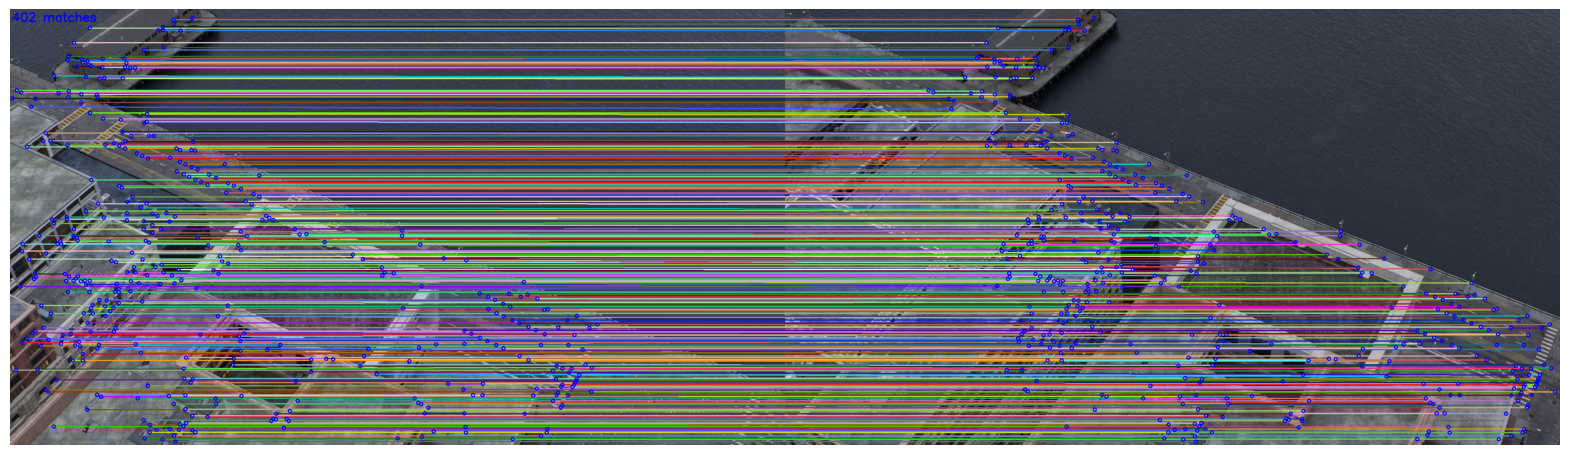

In [219]:
# Visualize.
print("> Visualizing matches...")
viz = utils.visualize_matches(
    image0,
    image1,
    match_kp0,
    match_kp1,
    np.eye(num_filtered_matches),
    show_keypoints=True,
    highlight_unmatched=True,
    title=f"{num_filtered_matches} matches",
    line_width=2,
)
plt.figure(figsize=(20, 10), dpi=100, facecolor="w", edgecolor="k")
plt.axis("off")
plt.imsave(f"{imageFolder}/matchresult.png",viz)
plt.imshow(viz)

## Calculating Relative Pose from Keypoint Matching

The calculation of relative pose from keypoint matching is a multi-step process that involves identifying, filtering, and analyzing feature points across multiple images to derive the spatial relationship between camera positions or objects in varying views. The following methodology outlines these steps in detail:

1. **Outlier Removal**:  
   Once feature matches are obtained, it’s essential to remove erroneous matches, as these can introduce inaccuracies in pose estimation. A RANSAC (Random Sample Consensus) algorithm is typically applied to filter out outlier matches, allowing us to focus only on reliable inliers that better represent the true geometric relationship.

2. **Estimating the Fundamental or Essential Matrix**:  
   Based on the calibration status of the images, the next step involves computing either the fundamental matrix $ F $ or the essential matrix $ E $:
   - For uncalibrated images, the fundamental matrix $ F $ is computed using algorithms like the eight-point or five-point method.
   - For calibrated images, the essential matrix $ E $ is derived using the camera intrinsic parameters, given by $ E = K^T \times F \times K $, where $ K $ is the camera’s intrinsic matrix.

3. **Decomposition of the Essential Matrix**:  
   The essential matrix $ E $ is then decomposed to retrieve the relative rotation matrix $ R $ and the translation vector $ t $ (which represents the translation direction rather than scale). Decomposition yields four possible solutions for $ R $ and $ t $, as the matrix $ E $ intrinsically includes certain ambiguities.

In [220]:
# 使用 RANSAC 方法计算基础矩阵 F 和 mask
F, mask = cv2.findFundamentalMat(match_kp0, match_kp1, method=cv2.RANSAC)
# 打印基础矩阵
print("Fundamental Matrix (F):")
print(F)

 # 使用 mask 过滤出内点（inliers），即通过 RANSAC 验证的匹配点
inlier_kp0 = match_kp0[mask.ravel() == 1]
inlier_kp1 = match_kp1[mask.ravel() == 1]
num_filtered_matches=len(inlier_kp0)

# print(f"Number of inliers: {len(inlier_kp0)}/{len(match_kp0)}")
# 保存内点
# 提取文件名
image0_name = os.path.basename(image0_fp).split('.')[0]  # 获取 IMG20241029135039
image1_name = os.path.basename(image1_fp).split('.')[0]  # 获取 IMG20241029135043
filename = f"{imageFolder}/{image0_name}##{image1_name}.npz"
np.savez(filename, inlier_kp0=inlier_kp0, inlier_kp1=inlier_kp1)

Fundamental Matrix (F):
[[ 1.69946827e-09  1.00271003e-06 -4.88545910e-04]
 [-3.06012176e-06  4.51888576e-06 -5.47405760e-01]
 [ 2.40966188e-03  5.41886332e-01  1.00000000e+00]]


To compute the **rotation matrix $R$** and **translation vector $t$** from the fundamental matrix $F$, we need to use the **essential matrix $E$**. The relationship between the fundamental matrix $F$ and the essential matrix $E$ is as follows:

$$
E = K^T \cdot F \cdot K
$$


Among them, $K$ is the **intrinsic parameter matrix** of the camera.

### Camera calibration

Calibrate the camera and obtain the camera internal parameter matrix by shooting the checkerboard pattern.

The checkerboard pattern image is from https://github.com/opencv/opencv/blob/master/doc/pattern.png. It's 9x6.

I put the printed checkerboard in different positions, angles and distances to shoot. At the same time to ensure that the checkerboard is clearly visible, to minimize reflection and out of focus. A total of 13 photos were taken, and the checkerboard in each image occupies a different area and angle.

In [221]:
import numpy as np
import cv2
import glob

# 棋盘格的尺寸 (内角点的数量)
pattern_size = (6, 9)

# 准备棋盘格的 3D 世界坐标点 (z = 0 平面)
objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[1], 0:pattern_size[0]].T.reshape(-1, 2)

# 用于存储所有图像的对象点和图像点
obj_points = []  # 3D 世界坐标
img_points = []  # 2D 图像坐标

# 读取拍摄的棋盘格图片
images = glob.glob('calibration/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 寻找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret:
        obj_points.append(objp)  # 添加 3D 点
        img_points.append(corners)  # 添加 2D 点

        # 显示角点
        img_with_corners = cv2.drawChessboardCorners(img, pattern_size, corners, ret)
        save_path = os.path.join('/home/arno/Projects/omniglue/calibration/output/', os.path.basename(fname))
        print(save_path)
        cv2.imwrite(save_path, img_with_corners)

# 标定相机
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

# 打印相机内参矩阵 K 和畸变系数
print("Camera Matrix (K):")
print(K)
print("Distortion Coefficients:")
print(dist)

# 保存标定结果
np.savez('calibration_data.npz', K=K, dist=dist, rvecs=rvecs, tvecs=tvecs)



# 获取所有需要校正的图片路径
image_paths = glob.glob('calibration/*.jpg')  # 替换为实际路径

# 遍历所有图片并进行校正
for img_path in image_paths:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # 获取新的相机矩阵和有效像素区域
    new_K, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))

    # 校正图像
    undistorted_img = cv2.undistort(img, K, dist, None, new_K)

    # 裁剪图像（只保留有效区域）
    x, y, w, h = roi
    undistorted_img = undistorted_img[y:y+h, x:x+w]

    # 生成保存路径并保存校正后的图像
    output_path = os.path.join('calibration/validation/', os.path.basename(img_path))
    cv2.imwrite(output_path, undistorted_img)

    print(f"Saved undistorted image: {save_path}")

print("All images have been undistorted and saved.")


In [222]:
K =  np.load('calibration_data.npz')["K"]

# 1. 使用基础矩阵 F 和内参矩阵 K 计算本质矩阵 E
E = np.dot(K.T, np.dot(F, K))  # E = K.T * F * K
# 2. 恢复相机的旋转矩阵 R 和平移向量 t
_, R, t, _ = cv2.recoverPose(E, inlier_kp0, inlier_kp1, K)
print("Rotation Matrix (R):")
print(R)
print("Translation Vector (t):")
print(t)

Rotation Matrix (R):
[[ 0.95189782 -0.04203517 -0.30351868]
 [ 0.11528135  0.96689772  0.22763791]
 [ 0.28390272 -0.25167807  0.9252337 ]]
Translation Vector (t):
[[ 0.98632439]
 [ 0.00113514]
 [-0.16481174]]


<div class="alert alert-info">
The Physical Dimensional Problem of the Translation Vector
</div>

In computer vision, the translation vector (t) represents the relative displacement between two camera positions. However, when estimating this vector from a single pair of images without any **prior information**, it is important to understand its inherent limitations.

#### **Lack of Physical Scale in Translation Vector**

The translation vector (t) computed from **two views** only provides the **direction** of the displacement between the two camera positions. This vector lacks **physical scale** (e.g., meters or centimeters) because:

1. **Absence of Scale Factor**:

  - The transformation from 3D world coordinates to 2D image coordinates through projection inherently loses depth information. As a result, **multiple 3D reconstructions** with different scales can result in identical 2D projections.

  - Consequently, the estimated translation vector (t) from a single image pair is inherently **up to scale**—only its direction is reliable, but the magnitude is arbitrary.

2. **Normalized Translation Vector**:

  - In implementations such as `cv2.recoverPose` from OpenCV, the returned translation vector is often **normalized** to unit length:
$||t||=1$

  - This normalization ensures that the vector describes only the **direction** between the two camera positions, but without any unit of measurement.

3. **Need for Additional Information**:

  - To determine the **actual physical scale** (e.g., meters), additional prior information is required:

    - **Real-world distance** between certain points in the scene.

    - **Known baseline** (physical distance) between two camera positions (as in **stereo cameras**).

    - **Simultaneous Localization and Mapping (SLAM)** algorithms, which accumulate information across multiple frames to infer the scale.



## **Verification of Relative Pose with a Single Image Pair**

In a stereo vision system, recovering accurate 3D coordinates of object points from a **single image pair** is inherently challenging due to the lack of sufficient depth information. While the **relative pose** (rotation (R) and translation (t)) between the two views can be estimated using matched keypoints, the 3D reconstruction is not accurate enough to produce meaningful reprojected 3D coordinates with low error. The ambiguity primarily arises from the scale ambiguity of the translation vector and the uncertainty in keypoint correspondences.



### **Method 1: Epipolar Geometry Constraint Verification**

The **epipolar constraint** ensures that the geometry between the two images is consistent with the computed **fundamental matrix (F)**. For any pair of matching points (\mathbf{x}_1) and (\mathbf{x}_2) from the two images, the following condition must hold:

$$
\mathbf{x}_2^T F \mathbf{x}_1 = 0
$$

This equation ensures that the corresponding points lie on their respective epipolar lines. In practice, due to numerical precision limitations and slight mismatches in keypoint detection, the constraint may not be exactly zero but should remain very close to it. By computing the **average epipolar constraint error** across all matched inlier keypoints, we can assess the validity of the estimated fundamental matrix (F) and, indirectly, the relative pose.

A low average error indicates that the fundamental matrix and the corresponding relative pose are likely accurate. If the error is high, this may suggest that either the keypoint matches are inaccurate, or there are errors in the pose estimation.



In [223]:
def verify_epipolar_constraint1(F, kp1, kp2):
    # 将关键点转换为齐次坐标 (x, y) -> (x, y, 1)
    kp1_h = np.hstack([kp1, np.ones((kp1.shape[0], 1))])
    kp2_h = np.hstack([kp2, np.ones((kp2.shape[0], 1))])

    # 计算对极几何约束的值：x2.T * F * x1
    errors = []
    for i in range(len(kp1)):
        error = np.abs(np.dot(kp2_h[i], np.dot(F, kp1_h[i].T)))
        errors.append(error)

    # 打印平均误差
    mean_error = np.mean(errors)
    print(f"Average Epipolar Constraint Error(closer to 0 is better): {mean_error}")
    return mean_error

# 使用内点关键点进行验证
v1=verify_epipolar_constraint1(F, inlier_kp0, inlier_kp1)

Average Epipolar Constraint Error(closer to 0 is better): 0.3188933185747523


### **Method 2: Reprojection Error Verification**

Another way to validate the estimated pose is by computing the **reprojection error**. This method involves using the relative pose (R) and (t) to reproject the 3D points back into the image planes of both views. Specifically:

1. The matched keypoints from the first image are back-projected into 3D space using the pose of the first camera.

2. These 3D points are then reprojected into the second image plane using the relative pose (R) and (t).

3. The difference between the reprojected points and the actual keypoints in the second image provides the reprojection error.

The reprojection error should ideally be as small as possible (typically below 1 pixel). However, in practice, it is challenging to achieve a low reprojection error with just a single image pair, due to:



# Supplement

In [224]:
print("Fundamental Matrix (F):")
print(F)
print("Rotation Matrix (R):")
print(R)
print("Translation Vector (t):")
print(t)
print(f"Average Epipolar Constraint Error(closer to 0 is better): {v1}")

Fundamental Matrix (F):
[[ 1.69946827e-09  1.00271003e-06 -4.88545910e-04]
 [-3.06012176e-06  4.51888576e-06 -5.47405760e-01]
 [ 2.40966188e-03  5.41886332e-01  1.00000000e+00]]
Rotation Matrix (R):
[[ 0.95189782 -0.04203517 -0.30351868]
 [ 0.11528135  0.96689772  0.22763791]
 [ 0.28390272 -0.25167807  0.9252337 ]]
Translation Vector (t):
[[ 0.98632439]
 [ 0.00113514]
 [-0.16481174]]
Average Epipolar Constraint Error(closer to 0 is better): 0.3188933185747523
